In [1]:
import sys
sys.path.append("/hpfs/userws/let55/projects/e3moldiffusion")

In [2]:
import os
import torch
import numpy as np
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem
from tqdm import tqdm 
from torch_geometric.data import Data
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')
from torch_scatter import scatter
from torch_geometric.utils import dense_to_sparse, sort_edge_index
import matplotlib.pyplot as plt
from collections import namedtuple
from datetime import datetime
from rdkit.Chem import rdDistGeom
import torch.nn.functional as F

from torch_geometric.data import Data, Batch 
import nglview
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from ase.visualize import view
from ase import Atoms
import torch_scatter
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
import ipywidgets
from ipywidgets import interact, interactive, fixed, IntSlider
import pickle
from rdkit import Chem, RDLogger
from rdkit.Geometry import Point3D
from rdkit.DataStructs import TanimotoSimilarity
from rdkit import DataStructs
from rdkit.Chem import AllChem
import nglview
IPythonConsole.ipython_useSVG = True 
IPythonConsole.molSize = 400, 400
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_3d = True

In [3]:
from experiments.data.config_file import get_dataset_info
from experiments.data.data_info import GeneralInfos as DataInfos
from experiments.data.geom.geom_dataset_adaptive import GeomDataModule

In [4]:
from experiments.utils import (
    coalesce_edges,
    get_molecules,
    load_bond_model,
    load_energy_model,
    load_model,
    zero_mean,
)

from experiments.diffusion.utils import (
    initialize_edge_attrs_reverse,
)


In [5]:
class TmpCfg():
    def __init__(self, dataset_root) -> None:
        self.remove_hs = False
        self.dataset = "geom"
        self.dataset_root = dataset_root
        self.batch_size = 32
        self.num_workers = 1
        self.num_bond_classes = 5
        self.num_charge_classes = 6
        self.select_train_subset = False
        self.inference_batch_size = 100

In [7]:
load_data = True
if load_data:
    root = "/hpfs/projects/mlcs/mlhub/e3moldiffusion/data/geom/data"
    cfg = TmpCfg(dataset_root=root)
    datamodule = GeomDataModule(cfg)
    datamodule.setup(stage="fit")
    dataset_info = DataInfos(datamodule, cfg)
    train_smiles = datamodule.train_dataset.smiles
    loader = datamodule.val_dataloader()
    data = next(iter(loader))
    data

In [14]:
eval_df = pd.read_csv("/hpfs/projects/mlcs/mlhub/e3moldiffusion/geomtuan/new_model_base_with_Hs_retrain/run0/evaluation.csv")
eval_df = eval_df.drop_duplicates()
eval_df = eval_df.drop(1,)
eval_df

,Unnamed: 0,mol_stable,atm_stable,validity,sanitize_validity,novelty,uniqueness,sampling/NumNodesW1,sampling/AtomTypesTV,sampling/EdgeTypesTV,...,LogP,MolWeight,HAcceptor,HDonor,Lipinski,Diversity,step,epoch,run_time,ngraphs
0,0.0,0.8960000276565552,0.9968181252479553,0.6980000138282776,0.77,1.0,1.0,0.5684537887573242,0.038238558918237686,0.024203144013881683,...,2.3795876361031527,349.9218954154729,5.4240687679083095,1.669054441260745,4.9426934097421205,0.7231732870216417,0,19,0:29:56.391716,1000
2,0.0,0.9190000295639038,0.9970349073410034,0.7279999852180481,0.798,0.9986263513565063,1.0,0.36653998494148254,0.034933075308799744,0.02503388002514839,...,2.446166565934067,344.5108722527473,5.321428571428571,1.5302197802197801,4.956043956043956,0.7353555718070877,1,39,0:29:20.181121,1000
4,0.0,0.9210000038146973,0.9976125955581665,0.7444999814033508,0.812,1.0,1.0,0.3965466618537903,0.03277989476919174,0.0252398531883955,...,2.475567489932887,349.62319060402695,5.336912751677852,1.5503355704697988,4.955704697986577,0.7204944831843806,2,59,0:29:51.310931,1000
6,0.0,0.902999997138977,0.9971097111701965,0.7480000257492065,0.805,0.9986631274223328,1.0,0.3420478403568268,0.03048744983971119,0.024395691230893135,...,2.5166491844919796,348.76115374331556,5.4171122994652405,1.5200534759358288,4.959893048128342,0.7275812538800212,3,79,0:29:50.362350,1000
8,0.0,0.9129999876022339,0.9977527260780334,0.7720000147819519,0.826,0.9987046718597412,1.0,0.45367899537086487,0.03120446763932705,0.024535737931728363,...,2.437037707253887,350.6845012953369,5.424870466321243,1.5932642487046633,4.936528497409326,0.7278615819005722,4,99,0:30:11.366457,1000
10,0.0,0.9089999794960022,0.9969593286514282,0.7559999823570251,0.805,0.9986772537231445,1.0,0.5028883218765259,0.029755957424640656,0.024835359305143356,...,2.4198039417989428,348.9923452380953,5.3505291005291005,1.5383597883597884,4.943121693121693,0.7298739581993422,5,119,0:30:16.217995,1000
12,0.0,0.9139999747276306,0.997443437576294,0.796999990940094,0.831,1.0,1.0,0.3345676362514496,0.03166068717837334,0.024412976577878,...,2.4429691844416572,350.3955922208282,5.348808030112924,1.5269761606022585,4.947302383939774,0.728937538682486,6,139,0:31:51.566506,1000
14,0.0,0.9100000262260437,0.9972591400146484,0.7829999923706055,0.826,1.0,1.0,0.6123148202896118,0.0344928540289402,0.025267094373703003,...,2.3781894380587496,350.404925925926,5.482758620689655,1.602809706257982,4.948914431673052,0.7238826010104332,7,159,0:31:17.433241,1000
16,0.0,0.9129999876022339,0.9970247149467468,0.7829999923706055,0.822,0.9987228512763977,1.0,0.48173680901527405,0.03143046051263809,0.02433452196419239,...,2.455882835249043,350.7921851851853,5.41890166028097,1.528735632183908,4.945083014048532,0.7239227618332271,8,179,0:31:23.372938,1000
18,0.0,0.9089999794960022,0.9974746108055115,0.7839999794960022,0.824,0.9987244606018066,1.0,0.42436230182647705,0.02677263878285885,0.02449781820178032,...,2.467277448979593,346.7440267857143,5.266581632653061,1.6045918367346939,4.927295918367347,0.7339665398848008,9,199,0:30:23.884782,1000


In [15]:
from experiments.diffusion_discrete import Trainer
path = "/hpfs/projects/mlcs/mlhub/e3moldiffusion/geomtuan/new_model_base_with_Hs_retrain/best_mol_stab.ckpt"
device = torch.device("cuda:0")

In [17]:
model = Trainer.load_from_checkpoint(path,
                                     dataset_info=dataset_info,
                                     smiles_list=list(train_smiles)
                                    ).to(device)

Loading from pre-trained model checkpoint...


In [20]:
total_res, all_generated_smiles, stable_molecules = model.generate_valid_samples(dataset_info=dataset_info,
                                                                                 ngraphs=200,
                                                                                 bs=50,
                                                                                 return_molecules=True,
                                                                                 verbose=True,
                                                                                 inner_verbose=True,
                                                                                 )

Creating 200 graphs in [50, 50, 50, 50] batches


100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.33it/s]


Analyzing molecule stability
Error messages: AtomValence 5, Kekulize 25, other 1,  -- No error 161
Validity over 200 molecules: 80.50%
Number of connected components of 200 molecules: mean:1.04 max:3.00
Connected components of 200 molecules: 96.00
Uniqueness over 200 molecules: 1.00
Novelty over 200 molecules: 1.00
Creating 200 graphs in [50, 50, 50, 50] batches


100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.25it/s]


Analyzing molecule stability
Error messages: AtomValence 15, Kekulize 12, other 0,  -- No error 159
Validity over 200 molecules: 79.50%
Number of connected components of 200 molecules: mean:1.07 max:2.00
Connected components of 200 molecules: 93.00
Uniqueness over 200 molecules: 1.00
Novelty over 200 molecules: 1.00
Analyzing molecule stability
Error messages: AtomValence 0, Kekulize 0, other 0,  -- No error 320
Validity over 320 molecules: 100.00%
Number of connected components of 320 molecules: mean:1.00 max:1.00
Connected components of 320 molecules: 100.00
Uniqueness over 320 molecules: 1.00
Novelty over 320 molecules: 1.00
Sparsity level on local rank 0: 95 %
Run time=0:14:31.325557
{'mol_stable': 0.987500011920929, 'atm_stable': 0.9997087717056274, 'validity': 1.0, 'sanitize_validity': 1.0, 'novelty': 1.0, 'uniqueness': 1.0, 'sampling/NumNodesW1': 1.9098894596099854, 'sampling/AtomTypesTV': 0.03258697688579559, 'sampling/EdgeTypesTV': 0.029408985748887062, 'sampling/ChargeW1': 0.

In [22]:
total_res

,mol_stable,atm_stable,validity,sanitize_validity,novelty,uniqueness,sampling/NumNodesW1,sampling/AtomTypesTV,sampling/EdgeTypesTV,sampling/ChargeW1,...,Num_Aromatic_Rings,SA,LogP,MolWeight,HAcceptor,HDonor,Lipinski,Diversity,run_time,ngraphs
0,0.9875,0.999709,1.0,1.0,1.0,1.0,1.909889,0.032587,0.029409,0.002648,...,2.146875,0.765844,2.6386,351.526631,5.434375,1.4625,4.965625,0.732051,0:14:31.325557,320


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

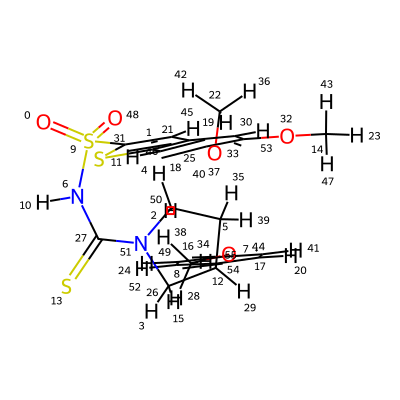

In [24]:
stable_molecules[0].rdkit_mol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

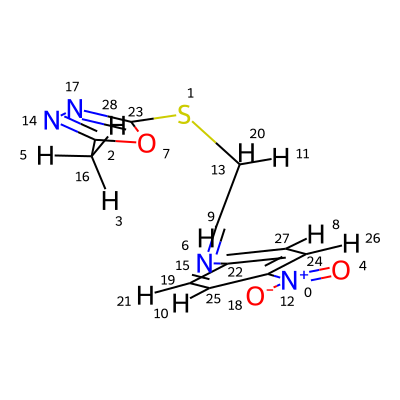

In [25]:
stable_molecules[1].rdkit_mol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

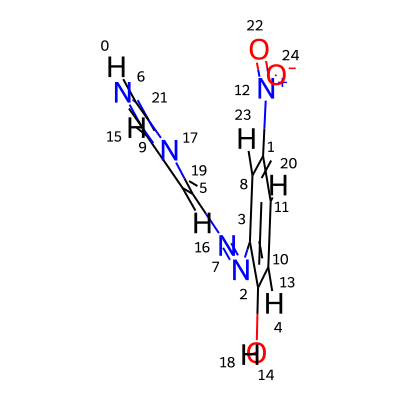

In [26]:
stable_molecules[-1].rdkit_mol